In [156]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [157]:
# data preprocessing 
def load(paths):
    '''expects images for each class in seperate dir, 
        e.g all digits in 0 class in the directory named 0 and so on.'''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels. Since jpeg images so cv2 will work on it
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        
       
    # return a tuple of the data and labels
    return data, labels

In [158]:
#get the path list using the path object
img_path = 'trainingSet'
image_paths = list(paths.list_images(img_path))



In [159]:
#apply our load function
image_list, label_list = load(image_paths)
#image_list
#label_list

In [160]:
from sklearn.preprocessing import LabelBinarizer
# since it is a multiclass classification so this will create a one-hot vector(one vesus all)
lb = LabelBinarizer()
#transforms multicalss labels to binary labels
label_list = lb.fit_transform(label_list)
#label_list


In [161]:
from sklearn.model_selection import train_test_split
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.2)

In [162]:
def create_clients(image_list, label_list, num_clients, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    # zip() with 2 arguments,the function will return an iterator
    # that generates tuples of length 2. then we make a list of tuples.
    data = list(zip(image_list, label_list))
    #randomize the data.
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}


In [163]:
#create clients
clients = create_clients(X_train, y_train, num_clients=21, initial='clients')

In [164]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds(tensorflow dataset) object 
    '''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [165]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [166]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Flatten(input_shape=(shape,)))
        #model.add(Activation("sigmoid"))
        #model.add(Activation("relu"))
        model.add(Dense(200, activation="relu"))
        #model.add(Activation("sigmoid"))
        #model.add(Activation("relu"))
        model.add(Dense(classes, activation="softmax"))
        #model.add(Activation("sigmoid"))
        #model.add(Activation("softmax"))
        # since MNIST is an exclusive classiication dataset so softmax activation function for output
        # layer and ReLU for hidden layers will work best 
        return model

In [167]:
model = SimpleMLP.build(784, 10)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________


In [168]:
model.layers

In [171]:
# we are using time-based decay here. it will reduce after every epoch by decay factor
# if we use the more number of epochs then step decay will be best suited 
lr = 0.02 #learning rate
update_round = 10
decay_rate = lr/update_round
loss='categorical_crossentropy' # since classification task
metrics = ['accuracy']
optimizer = SGD(lr=lr, decay=decay_rate, momentum=0.8, nesterov=False)

'''
Momentum is an argument in SGD optimizer which we could tweak to obtain faster convergence.
Unlike classical SGD, momentum method helps the parameter vector to build up velocity in any 
direction with constant gradient descent so as to prevent oscillations. A typical choice of 
momentum is between 0.5 to 0.9
'''
#from tensorflow.keras.optimizers import Adadelta
#optimizer = Adadelta(lr=lr, rho=0.95, epsilon=1e-08, decay=0.0)

'\nMomentum is an argument in SGD optimizer which we could tweak to obtain faster convergence.\nUnlike classical SGD, momentum method helps the parameter vector to build up velocity in any \ndirection with constant gradient descent so as to prevent oscillations. A typical choice of \nmomentum is between 0.5 to 0.9\n'

 now we are estimating the weight parameters for each client based on the loss values recorded across every data point they trained with. On the left, we scaled each of those parameters and sum them all component-wise.

In [172]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

In [173]:
def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [174]:
def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [175]:
def test_model(X_test, Y_test,  model, update_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('update_round: {} | global_acc: {:.5%} | global_loss: {:.6%}'.format(update_round, acc, loss))
    return acc, loss

In [176]:
#initialize global model: using multi-layer-perceptron model
smlp_global = SimpleMLP()
# .build method automatically builds the MLP model on our data
global_model = smlp_global.build(784, 10)

#commence global training loop
for update_round in range(update_round):
            
    # weight intialisation
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        # this creates the mlp model for the clients. 
        # we can also create deiffenrt model for each client
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
                      
                      
        #set local model weight to the weight of the global model that acts as the initial update 
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, update_round)
    

50/50 [==============================] - 0s 2ms/step - loss: 2.0324 - accuracy: 0.3364
update_round: 0 | global_acc: 81.95238% | global_loss: 196.386909%
50/50 [==============================] - 0s 2ms/step - loss: 0.9072 - accuracy: 0.8162
update_round: 1 | global_acc: 84.50000% | global_loss: 187.096465%
50/50 [==============================] - 0s 2ms/step - loss: 0.7431 - accuracy: 0.8500
update_round: 2 | global_acc: 85.53571% | global_loss: 183.153093%
50/50 [==============================] - 0s 2ms/step - loss: 0.6328 - accuracy: 0.8635
update_round: 3 | global_acc: 85.91667% | global_loss: 180.788112%
50/50 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.8533
update_round: 4 | global_acc: 86.27381% | global_loss: 179.238534%
50/50 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.8744
update_round: 5 | global_acc: 86.59524% | global_loss: 178.091073%
50/50 [==============================] - 0s 2ms/step - loss: 0.5945 - accura

In [177]:
global_acc, global_loss

(0.8726190476190476, <tf.Tensor: shape=(), dtype=float32, numpy=1.7540141>)

# Now comparing it with SGD mehtod

In [178]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# fit the SGD training data to model
history = SGD_model.fit(SGD_dataset, epochs=10)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
       SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/10
105/105 [==============================] - 1s 7ms/step - loss: 2.2291 - accuracy: 0.1779
Epoch 2/10
105/105 [==============================] - 1s 7ms/step - loss: 1.8073 - accuracy: 0.5874
Epoch 3/10
105/105 [==============================] - 1s 7ms/step - loss: 1.4886 - accuracy: 0.7121
Epoch 4/10
105/105 [==============================] - 1s 7ms/step - loss: 1.2500 - accuracy: 0.7560
Epoch 5/10
105/105 [==============================] - 1s 7ms/step - loss: 1.0689 - accuracy: 0.7875
Epoch 6/10
105/105 [==============================] - 1s 7ms/step - loss: 0.9518 - accuracy: 0.8025
Epoch 7/10
105/105 [==============================] - 1s 9ms/step - loss: 0.8596 - accuracy: 0.8156
Epoch 8/10
105/105 [==============================] - 1s 8ms/step - loss: 0.7867 - accuracy: 0.8277
Epoch 9/10
105/105 [==============================] - 1s 9ms/step - loss: 0.7315 - accuracy: 0.8354: 0s - loss: 0.7369 - ac
Epoch 10/10
105/105 [==============================] - 1s 8ms/step - loss: 0

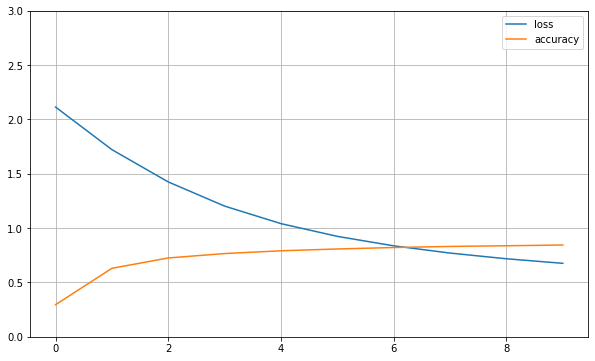

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

in the above learning curve we can see that the loss is decreasing, so we increase the number of epochs. For better understanding on fitting the data to model we can create a validation set that will also tell us the case of overfitting and underfitting

## considering non-IID data 

In [55]:
def non_iid_x(image_list, label_list, x=1, num_intraclass_clients=21):
        ''' creates x non_IID clients
        args: 
            image_list: python list of images or data points
            label_list: python list of labels
            x: none IID severity, 1 means each client will only have one class of data
            num_intraclass_client: number of sub-client to be created from each none IID class,
            e.g for x=1, we could create 10 further clients by splitting each class into 10
            
        return - dictionary 
            keys - clients's name, 
            value - client's non iid 1 data shard (as tuple list of images and labels) '''
        
        non_iid_x_clients = dict()
        
        #create unique label list and shuffle
        unique_labels = np.unique(np.array(label_list))
        random.shuffle(unique_labels)
        
        #create sub label lists based on x
        sub_lab_list = [unique_labels[i:i + x] for i in range(0, len(unique_labels), x)]
            
        for item in sub_lab_list:
            class_data = [(image, label) for (image, label) in zip(image_list, label_list) if label in item]
            
            #decouple tuple list into seperate image and label lists
            images, labels = zip(*class_data)
            
            # create formated client initials
            initial = ''
            for lab in item:
                initial = initial + str(lab) + '_'
            
            #create num_intraclass_clients clients from the class 
            intraclass_clients = create_clients(list(images), list(labels), num_intraclass_clients, initial)
            
            #append intraclass clients to main clients'dict
            non_iid_x_clients.update(intraclass_clients)
        
        return non_iid_x_clients

In [56]:
non_iid_clients = non_iid_x(image_list, label_list, 1, 21)

In [57]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds(tensorflow dataset) object 
    '''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [58]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in non_iid_clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [59]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

In [60]:
def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [61]:
def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [62]:
#initialize global model: using multi-layer-perceptron model
smlp_global = SimpleMLP()
# .build method automatically builds the MLP model on our data
global_model = smlp_global.build(784, 10)
        
#commence global training loop
for update_round in range(update_round):
            
    # weight intialisation
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        # this creates the mlp model for the clients. 
        # we can also create deiffenrt model for each client
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
                      
                      
        #set local model weight to the weight of the global model that acts as the initial update 
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, update_round)

63/63 [==============================] - 0s 1ms/step - loss: 2.3178 - accuracy: 0.1306
update_round: 0 | global_acc: 25.44048% | global_loss: 227.867889%
63/63 [==============================] - 0s 2ms/step - loss: 2.1088 - accuracy: 0.2764
update_round: 1 | global_acc: 39.36905% | global_loss: 225.814366%
63/63 [==============================] - 0s 1ms/step - loss: 1.9732 - accuracy: 0.4132
update_round: 2 | global_acc: 52.39286% | global_loss: 223.873949%
63/63 [==============================] - 0s 1ms/step - loss: 1.8537 - accuracy: 0.5418
update_round: 3 | global_acc: 61.27381% | global_loss: 222.046256%
63/63 [==============================] - 0s 2ms/step - loss: 1.7534 - accuracy: 0.6104
update_round: 4 | global_acc: 66.17857% | global_loss: 220.336509%
63/63 [==============================] - 0s 1ms/step - loss: 1.6930 - accuracy: 0.6390
update_round: 5 | global_acc: 68.96429% | global_loss: 218.738818%
63/63 [==============================] - 0s 1ms/step - loss: 1.6060 - accura

In [63]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# fit the SGD training data to model
history = SGD_model.fit(SGD_dataset, epochs=10)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
       SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/10
105/105 [==============================] - 1s 6ms/step - loss: 2.3564 - accuracy: 0.1189
Epoch 2/10
105/105 [==============================] - 1s 6ms/step - loss: 2.1952 - accuracy: 0.2435
Epoch 3/10
105/105 [==============================] - 1s 7ms/step - loss: 2.0634 - accuracy: 0.3707
Epoch 4/10
105/105 [==============================] - 1s 7ms/step - loss: 1.9490 - accuracy: 0.4685
Epoch 5/10
105/105 [==============================] - 1s 7ms/step - loss: 1.8413 - accuracy: 0.5511
Epoch 6/10
105/105 [==============================] - 1s 6ms/step - loss: 1.7430 - accuracy: 0.6101
Epoch 7/10
105/105 [==============================] - 1s 7ms/step - loss: 1.6480 - accuracy: 0.6559
Epoch 8/10
105/105 [==============================] - 1s 7ms/step - loss: 1.5603 - accuracy: 0.6865
Epoch 9/10
105/105 [==============================] - 1s 6ms/step - loss: 1.4820 - accuracy: 0.7095
Epoch 10/10
105/105 [==============================] - 1s 6ms/step - loss: 1.4083 - accuracy: 0.7255

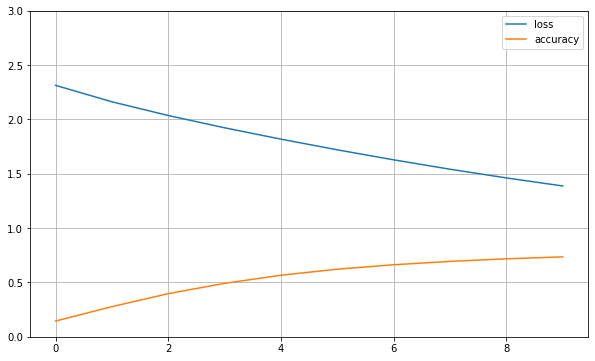

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

In this setup, we can see that non_iid_data learns very slow with respect to iid_data but the positive point is that accuracy is increasing and loss is decreasing.  